# Reinforcement learning
### Snake - Monte Carlo
Play games and iteratively improve the state values and corresponding policy

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML, Image

### Setup

In [12]:
'''Modified with improved 'graphics' '''

import numpy as np

im = 5

class Game():
    
    def __init__(self,grid,snake_size, snake_pad=2):
        self.board = np.ones((grid,grid,3))
        self.image = np.ones((grid*im,grid*im,3))
        self.snake = Snake(self.board,snake_size)
        self.pad = snake_pad
        self.apple = None
        self.score = 0
        self.total = 0
        self.deaths = 0

    def reset(self):
        self.snake.reset(self.pad)
        self.spawn_apple()

    def draw(self):
        # white background
        self.board[:,:,:] = 1
        self.image[:,:,:] = 1
        # black snake
        
        # head
        x,y = self.snake.pos
        self.board[x,y,:] = 0
        self.image[x*im:(x+1)*im,y*im:(y+1)*im,:] = 0
        d = self.snake.d
        xx,yy = [((x+1)*im-1,(y+1)*im-1),((x)*im,(y+1)*im-1),(x*im,y*im),(x*im,y*im)][d]
        self.image[xx,yy,:] = 1
        xx,yy = [((x+1)*im-1,y*im),((x+1)*im-1,(y+1)*im-1),(x*im,(y+1)*im-1),((x+1)*im-1,y*im)][d]
        self.image[xx,yy,:] = 1

        for s in self.snake.segments[1:]:
            x,y = s
            self.board[x,y,:] = 0
            self.image[x*im:(x+1)*im,y*im:(y+1)*im,:] = 0
        # tail
        if (len(self.snake.segments)>0):
            x,y = self.snake.segments[0]
            self.board[x,y,:] = 0    
            #self.image[x*im:(x+1)*im,y*im:(y+1)*im,1] = 0
            if (len(self.snake.segments)>1):
                n,m = self.snake.segments[1]
            else:
                n,m = self.snake.pos
            if (n==x and m>y):
                self.image[x*im:(x+1)*im,(y+1)*im-1,:] = 0
                self.image[x*im+1:(x+1)*im-1,(y+1)*im-2,:] = 0
                self.image[x*im+1:(x+1)*im-1,(y+1)*im-3,:] = 0
                self.image[x*im+2:(x+1)*im-2,(y+1)*im-4,:] = 0
                self.image[x*im+2:(x+1)*im-2,(y+1)*im-5,:] = 0
            elif (n==x and m<y):
                self.image[x*im:(x+1)*im,(y+1)*im-5,:] = 0
                self.image[x*im+1:(x+1)*im-1,(y+1)*im-4,:] = 0
                self.image[x*im+1:(x+1)*im-1,(y+1)*im-3,:] = 0
                self.image[x*im+2:(x+1)*im-2,(y+1)*im-2,:] = 0
                self.image[x*im+2:(x+1)*im-2,(y+1)*im-1,:] = 0
            elif (n<x and m==y):
                self.image[(x+1)*im-5,y*im:(y+1)*im,:] = 0
                self.image[(x+1)*im-4,y*im+1:(y+1)*im-1,:] = 0
                self.image[(x+1)*im-3,y*im+1:(y+1)*im-1,:] = 0
                self.image[(x+1)*im-2,y*im+2:(y+1)*im-2,:] = 0
                self.image[(x+1)*im-1,y*im+2:(y+1)*im-2,:] = 0
            elif (n>x and m==y):
                self.image[(x+1)*im-1,y*im:(y+1)*im,:] = 0
                self.image[(x+1)*im-2,y*im+1:(y+1)*im-1,:] = 0
                self.image[(x+1)*im-3,y*im+1:(y+1)*im-1,:] = 0
                self.image[(x+1)*im-4,y*im+2:(y+1)*im-2,:] = 0
                self.image[(x+1)*im-5,y*im+2:(y+1)*im-2,:] = 0
                
        # red apple
        x,y = self.apple
        self.board[x,y,1:] = 0
        self.image[x*im:(x+1)*im,y*im:(y+1)*im,1:] = 0
        for i in range(2):
            for j in range(2):
                self.image[(x+i)*im-i,(y+j)*im-j,:] = 1

    def spawn_apple(self):
        # dummy x,y for while loop
        x,y = self.snake.pos
        # keep generating new apples until a free cell is rolled
        while ((x,y) in self.snake.segments+[self.snake.pos]):
            x = np.random.randint(self.board.shape[0])
            y = np.random.randint(self.board.shape[1])
        self.apple = np.array([x,y],dtype=int)

    def iterate(self):
        reward = 0
        episode = 0
        # move snake
        self.snake.move()
        # check death condition
        grid = len(self.board)
        p = self.snake.pos
        a = self.apple
        if ((p[0]<0 or p[0]>=grid or p[1]<0 or p[1]>=grid) or (p in self.snake.segments)):
            self.lose()
            episode = -1
            reward = -1
        elif (p == a).all():
            # eat apple
            self.eat()
            episode = 1
            reward = 1
        return reward, episode

    def lose(self):
        self.reset()
        self.score=0
        self.deaths+=1

    def eat(self):
        self.snake.eat()
        self.score+=1
        self.total+=1
        old = self.apple
        self.spawn_apple()

    def get_state(self):
        grid = len(self.board)
        state = np.zeros(6)
        x,y = self.snake.pos
        'S,E,N,W'
        if ((x+1,y) in self.snake.segments or x+1>=grid):
            state[0] = 1
        if ((x-1,y) in self.snake.segments or x-1<0):
            state[2] = 1
        if ((x,y+1) in self.snake.segments or y+1>=grid):
            state[1] = 1
        if ((x,y-1) in self.snake.segments or y-1<0):
            state[3] = 1
        state[4] = np.sign(x-self.apple[0])
        state[5] = np.sign(y-self.apple[1])
        return state

class Snake():
    
    movement = ([[1,0],[0,1],[-1,0],[0,-1]])
    
    def __init__(self,board,starting_size):
        # the board on which the snake is moving
        self.grid = board.shape
        # position of head
        self.pos = None
        # direction facing
        self.d = 0
        # number of tail segments
        self.size = starting_size
        self.s_size = starting_size
        # position of tail segments
        self.segments = []
    
    def reset(self,pad=2):
        # pad starting position
        x = np.random.randint(pad,self.grid[0]-pad)
        y = np.random.randint(pad,self.grid[1]-pad)
        self.pos = (x,y)
        self.d = np.random.randint(4)
        self.size = self.s_size
        self.segments = []
        
    def move(self):
        # add head's position to segments
        self.segments.append(self.pos)
        # move head
        x,y = self.pos
        dx,dy = self.movement[self.d]
        self.pos = (x+dx,y+dy)
        # remove one segment if needed
        seg = None
        if (len(self.segments)>self.size):
            seg = self.segments.pop(0)
        # return new position and position that has been cleared
        return self.pos, seg
    
    def eat(self):
        self.size+=1

In [13]:
# modified dictionary that incorporates random defaults and epsilon greedy
class Policy(dict):
    
    import random
    
    def __init__(self,actions,epsilon=0.1):
        '''
        A policy with built in epsilon greedy and a uniform random choice for non initialized keys 
        actions - list of all possible actions
        epsilon - chance for explore
        '''
        self.actions = actions
        self.eps = epsilon
        super().__init__(self)
        
    def __getitem__(self, key):
        c = random.random()
        if (c<self.eps or key not in self):
            return self.actions[random.randint(0,len(self.actions)-1)]
        else:
            return super().__getitem__(key)

In [52]:
# game parameters
grid = 8
s_size = 3
# start game
game = Game(grid, s_size)
game.reset()

# discount factor
g = 0.9

# initialize policy
policy = Policy([0,1,2,3])

# dummy state for a lost game
LOSS = tuple(np.ones(6)*-1)

### Learning

In [53]:
# aggregated values for states and actions
agg = {}
# calculated Q values
Q = {}

# initialize policy
policy = Policy([0,1,2,3])

# run MC loop
for i in range(20000):
    # play one episode
    # game log
    history = []
    r = 0
    score = 0
    turns = 0
    while (True):
        # count turns (success in terms of not dying)
        turns+=1
        # count score
        if (game.score>score):
            score = game.score
        # get current state
        s = tuple(game.get_state())
        # choose action
        a = policy[s]
        # update history before moving to the next state
        history.append((s,r,a))
        # apply action
        game.snake.d = a
        # run one game step, get reward and check if episode is finished
        r,e = game.iterate() 
        if (e==-1):
            # game is lost, add final dummy state
            history.append((LOSS,r,0))
            # start a new episode
            break
        if (e==1):
            # eat apple, add modified state
            eat = np.array(s)
            eat[-2:] = 0
            history.append((tuple(eat),r,0))
            r = 0
    # update Q returns (values for this episode)
    q_values = []
    value = 0
    for s,r,a in reversed(history):
        q_values.append((s,a,value))
        # update value
        value = r + g*value
    q_values.reverse()
    # update aggregated q_values
    for s,a,v in q_values:
        # aggregated values
        if ((s,a) in agg):
            agg[(s,a)].append(v)
        else:
            agg[(s,a)] = [v]
        # average
        if (s in Q):
            Q[s][a] = np.mean(agg[(s,a)])
        else:
            Q[s] = {}
            Q[s][a] = np.mean(agg[(s,a)])
    # update policy
    for s in Q:
        aq = ([i for i in Q[s].items()])
        a = np.argmax([i[1] for i in aq])
        policy[s] = [i[0] for i in aq][a]
    # print progress
    if (i%1000==0):
        print(i,turns,score)

0 2 0
1000 22 3
2000 13 1
3000 4 0
4000 21 2
5000 9 1
6000 5 0
7000 8 1
8000 23 2
9000 19 3
10000 19 4
11000 66 10
12000 29 5
13000 38 5
14000 29 5
15000 33 6
16000 10 2
17000 34 5
18000 12 2
19000 19 2


### Animation

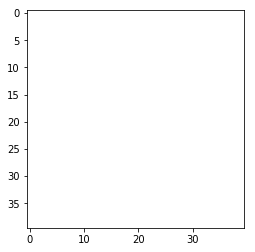

In [54]:
# render a game animation
fig, ax = plt.subplots()
image = ax.imshow(game.image)

g = Game(grid, s_size)
g.reset()

policy.eps = 0

def init():
    image.set_data(g.image)
    return (image,)

def animate(i):
    s = g.get_state()
    a = policy[tuple(s)]
    g.snake.d = a
    g.iterate() 
    g.draw()
    image.set_data(g.image)
    
    return (image,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=600, interval=120, 
                               blit=True)

In [55]:
anim.save('./movies/iter20000.gif', writer='imagemagick', fps=18)

In [56]:
Image(url='./movies/iter20000.gif')

In [51]:
Image(url='./movies/iter5000.gif')

In [46]:
Image(url='./movies/iter1000.gif')

In [41]:
Image(url='./movies/iter100.gif')

In [35]:
Image(url='./movies/iter1.gif')